# Project 4: Binary Image Classification

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

#### Dataset

The dataset is already labelled and split into training and test sets. The classes are slightly imbalanced and therefore, F1-score is also considered here for evaluation rather than just depending on the accuracy.

Sample images of a flipped and non-flipped page is shown below.

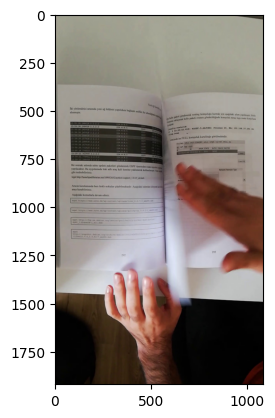

In [2]:
# Flipped Page
image_flip = cv2.imread('images/training/flip/0065_000000021.jpg')
image_flip = cv2.cvtColor(image_flip, cv2.COLOR_BGR2RGB)
plt.imshow(image_flip)

In [4]:
# Get image size and color channels
height, width, channels = image_flip.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

Width: 1080, Height: 1920, Channels: 3


Each image in the dataset has a resolution of 1920 x 1080 pixels. For faster processing, these images have been resized to one-twentieth of their original size, maintaining the aspect ratio, resulting in a resolution of 96 x 54 pixels.

The dataset is processed using the Image Generator from the Keras library. Additionally, several data augmentation techniques have been applied to the training set, as given below.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'images/training'
test_dir = 'images/testing'

# Some data augmentation is applied
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               classes = ['flip', 'notflip'],
                                               target_size = (200, 200),
                                               batch_size = 32,
                                               class_mode = 'binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                             classes = ['flip', 'notflip'],
                                             target_size = (200, 200),
                                             batch_size = 32,
                                             class_mode = 'binary',
                                             shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


### Image Classification with CNN

For classification, CNN with 2 convolutional layers is modelled and compiled with Adam optimizer.

In [21]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (200, 200, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
steps_train = np.ceil(train_data.samples/train_data.batch_size)
steps_test = np.ceil(test_data.n / test_data.batch_size)

In [24]:
history = model.fit(
    train_data,
    steps_per_epoch = steps_train,
    epochs = 15,
    validation_data = test_data,
    validation_steps = steps_test) 

Epoch 1/15
75/75 [==============================] - 277s 4s/step - loss: 0.9088 - accuracy: 0.5109 - val_loss: 0.6789 - val_accuracy: 0.6549
Epoch 2/15
75/75 [==============================] - 252s 3s/step - loss: 0.6898 - accuracy: 0.5518 - val_loss: 0.6739 - val_accuracy: 0.5980
Epoch 3/15
75/75 [==============================] - 251s 3s/step - loss: 0.6689 - accuracy: 0.5962 - val_loss: 0.6582 - val_accuracy: 0.6265
Epoch 4/15
75/75 [==============================] - 253s 3s/step - loss: 0.6433 - accuracy: 0.6275 - val_loss: 0.5857 - val_accuracy: 0.7018
Epoch 5/15
75/75 [==============================] - 247s 3s/step - loss: 0.6284 - accuracy: 0.6442 - val_loss: 0.5439 - val_accuracy: 0.7571
Epoch 6/15
75/75 [==============================] - 252s 3s/step - loss: 0.5857 - accuracy: 0.6865 - val_loss: 0.4935 - val_accuracy: 0.7588
Epoch 7/15
75/75 [==============================] - 251s 3s/step - loss: 0.5537 - accuracy: 0.7128 - val_loss: 0.4400 - val_accuracy: 0.8007
Epoch 8/15
75

### Results

In [25]:
test_data.reset()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, steps = steps_test)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_data, steps = steps_test)

19/19 [==============================] - 27s 1s/step - loss: 0.2673 - accuracy: 0.9028
Test accuracy: 0.9028475880622864
19/19 [==============================] - 23s 1s/step


In [26]:
from sklearn.metrics import classification_report

test_data.reset()

test_labels = test_data.classes
binary_predictions = (predictions > 0.5).astype(int)

# Generate the classification report
report = classification_report(test_labels, binary_predictions.flatten(), target_names=test_data.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        flip       0.90      0.90      0.90       290
     notflip       0.91      0.91      0.91       307

    accuracy                           0.90       597
   macro avg       0.90      0.90      0.90       597
weighted avg       0.90      0.90      0.90       597



The CNN model gives an accuracy and f1-score of around 87%.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'images/training'
test_dir = 'images/testing'

# Some data augmentation is applied
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               classes = ['flip', 'notflip'],
                                               target_size = (96, 54),
                                               batch_size = 32,
                                               class_mode = 'binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                             classes = ['flip', 'notflip'],
                                             target_size = (96, 54),
                                             batch_size = 32,
                                             class_mode = 'binary',
                                             shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [28]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (96, 54, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [29]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
history = model.fit(
    train_data,
    steps_per_epoch = steps_train,
    epochs = 15,
    validation_data = test_data,
    validation_steps = steps_test) 

Epoch 1/15
75/75 [==============================] - 92s 1s/step - loss: 0.6896 - accuracy: 0.5334 - val_loss: 0.6646 - val_accuracy: 0.5645
Epoch 2/15
75/75 [==============================] - 91s 1s/step - loss: 0.6503 - accuracy: 0.6204 - val_loss: 0.5479 - val_accuracy: 0.7571
Epoch 3/15
75/75 [==============================] - 91s 1s/step - loss: 0.5848 - accuracy: 0.7011 - val_loss: 0.4268 - val_accuracy: 0.8191
Epoch 4/15
75/75 [==============================] - 87s 1s/step - loss: 0.5314 - accuracy: 0.7383 - val_loss: 0.4132 - val_accuracy: 0.8275
Epoch 5/15
75/75 [==============================] - 87s 1s/step - loss: 0.4817 - accuracy: 0.7705 - val_loss: 0.3042 - val_accuracy: 0.9045
Epoch 6/15
75/75 [==============================] - 89s 1s/step - loss: 0.4502 - accuracy: 0.7851 - val_loss: 0.3530 - val_accuracy: 0.8476
Epoch 7/15
75/75 [==============================] - 88s 1s/step - loss: 0.3911 - accuracy: 0.8219 - val_loss: 0.2433 - val_accuracy: 0.9062
Epoch 8/15
75/75 [==

In [32]:
test_data.reset()

# Make predictions
predictions = model.predict(test_data, steps = steps_test)

19/19 [==============================] - 14s 720ms/step
              precision    recall  f1-score   support

        flip       0.96      0.90      0.93       290
     notflip       0.91      0.97      0.94       307

    accuracy                           0.94       597
   macro avg       0.94      0.94      0.94       597
weighted avg       0.94      0.94      0.94       597



In [37]:
test_labels = test_data.classes
binary_predictions = (predictions > 0.2).astype(int)

# Generate the classification report
report = classification_report(test_labels, binary_predictions.flatten(), target_names=test_data.class_indices.keys())
print(report)

              precision    recall  f1-score   support

        flip       1.00      0.83      0.90       290
     notflip       0.86      1.00      0.92       307

    accuracy                           0.91       597
   macro avg       0.93      0.91      0.91       597
weighted avg       0.93      0.91      0.91       597

